In [1]:
import numpy as np
import pandas as pd
import preprocess_data as prep
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from models import build_baseline, train_model_using_cross_val, sum_regions_predictions
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)

In [2]:
STATE = 'PR'
TEST_YEAR = 2023

In [3]:
df = prep.load_cases_data()
df = df.loc[df.uf == STATE]
enso = prep.load_enso_data()

# generate the samples to train and test based on the regional data 
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

In [4]:
LOSS = 'mse'

In [5]:
batch_size = 4
model = build_baseline( hidden=64, features=8, predict_n=52, look_back=89, loss=LOSS, 
                  stateful = False, batch_size = batch_size,  optimizer = Adam(learning_rate=0.001), activation = 'relu')

model 

/opt/homebrew/Caskroom/miniforge/base/envs/train_lstm/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (4, 89, 8)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (4, 89, 64)            │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (4, 89, 64)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (4, 64)                │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (4, 64)                │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (4, 52)                │         3,380 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 55,092 (215.20 KB)

 Trainable params: 55,092 (215.20 KB)

 Non-trainable params: 0 (0.00 B)

None


<Functional name=functional, built=True>

In [6]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [7]:
epochs = 600

In [8]:
TB_callback = TensorBoard(
            log_dir="./tensorboard",
            histogram_freq=0,
            write_graph=True,
            write_images=True,
            update_freq='epoch',
            # embeddings_freq=10
        )

hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=epochs,
                verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )


Epoch 1/600
42/42 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.0683 - loss: 0.0150 - mape: 2034345.7500 - mse: 0.0150 - val_accuracy: 0.1091 - val_loss: 0.0088 - val_mape: 2184673.5000 - val_mse: 0.0088
Epoch 2/600
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1099 - loss: 0.0128 - mape: 2431546.0000 - mse: 0.0128 - val_accuracy: 0.0364 - val_loss: 0.0087 - val_mape: 2406538.5000 - val_mse: 0.0087
Epoch 3/600
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0732 - loss: 0.0146 - mape: 2032970.6250 - mse: 0.0146 - val_accuracy: 0.1273 - val_loss: 0.0088 - val_mape: 2755211.2500 - val_mse: 0.0088
Epoch 4/600
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.0664 - loss: 0.0166 - mape: 3388919.5000 - mse: 0.0166 - val_accuracy: 0.1273 - val_loss: 0.0087 - val_mape: 2206574.5000 - val_mse: 0.0087
Epoch 5/600
42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0965 - loss: 0.0138 - mape: 2486313.0000 - mse: 0.0138 - val_accuracy: 0.0545 - val_loss: 0.0086 - val_mape: 2

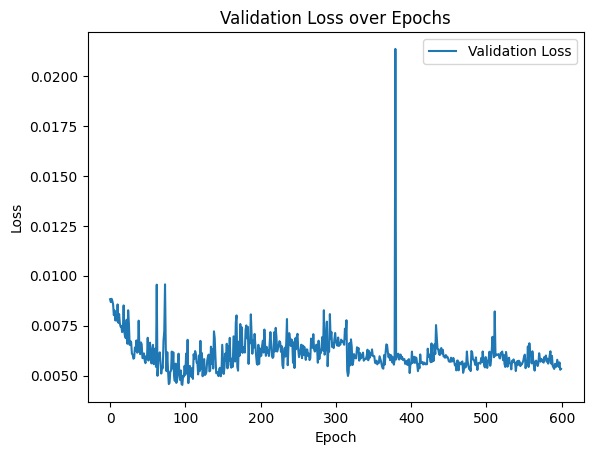

In [9]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

In [10]:
model_name = 'baseline'
columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                           'peak_week', 'perc_geocode']

In [11]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_23 = sum_regions_predictions(model, df, enso, TEST_YEAR, columns_to_normalize, True, False)

df_preds_23['adm_1'] = STATE
df_preds_23['adm_0'] = 'BR'
df_preds_23['adm_2'] = pd.NA

df_preds_23.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 5min 14s, sys: 1.05 s, total: 5min 15s
Wall time: 5min 21s


In [12]:
df_23_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_23_base.dates = pd.to_datetime(df_23_base.dates)
df_23_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,0.000000,0.000000,3.042153,PR,BR,NaN
1,2022-10-16,0.000000,0.000000,63.610485,PR,BR,NaN
2,2022-10-23,0.000000,0.000000,0.000000,PR,BR,NaN
3,2022-10-30,50.033301,167.943294,283.553875,PR,BR,NaN
4,2022-11-06,0.000000,0.000000,35.953828,PR,BR,NaN


In [13]:
df_preds_23.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2022-10-09,124.766294,364.150631,580.023380,PR,BR,<NA>
1,2022-10-16,7.431376,72.042672,191.756100,PR,BR,<NA>
2,2022-10-23,0.000000,0.000000,0.000000,PR,BR,<NA>
3,2022-10-30,204.528295,354.542292,503.036117,PR,BR,<NA>
4,2022-11-06,552.435905,716.754708,843.053313,PR,BR,<NA>


In [14]:
data_w = df[['casos']].resample('W-SUN').sum()

data_w.head()

,casos
date,
2010-01-03,369
2010-01-10,386
2010-01-17,529
2010-01-24,716
2010-01-31,956


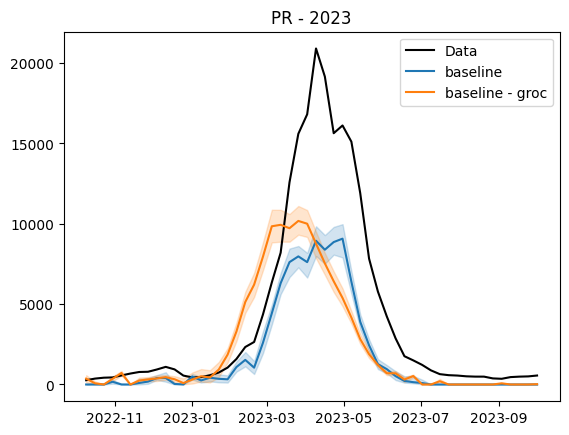

In [15]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_23_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_23_base.dates, df_23_base.preds, label ='baseline')
ax.fill_between(df_23_base.dates, df_23_base.lower, df_23_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_23.dates, df_preds_23.preds, label ='baseline - groc')

ax.fill_between(df_preds_23.dates, df_preds_23.lower, df_preds_23.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()

### Training the model for 2024:

In [21]:
from keras.models import load_model

model = load_model(f'./saved_models/model_groc_{STATE}_2022_{model_name}.keras')

In [22]:
TEST_YEAR = 2024

In [23]:
X_train, y_train = prep.generate_regional_train_samples(df, enso, TEST_YEAR, columns_to_normalize=['casos','epiweek', 'enso', 'R0', 'total_cases',
                                                                                                  'peak_week', 'perc_geocode'], episcanner = True)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=42)

In [24]:
hist = model.fit(
                X_train,
                y_train,
                batch_size=4,
                epochs=600,
                verbose=1,
                validation_data=(X_val, y_val),
                callbacks=[TB_callback]
                )

Epoch 1/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.2550 - loss: 0.0029 - mape: 1494155.7500 - mse: 0.0029 - val_accuracy: 0.1803 - val_loss: 0.0051 - val_mape: 505992.0000 - val_mse: 0.0051
Epoch 2/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.2085 - loss: 0.0019 - mape: 706302.1250 - mse: 0.0019 - val_accuracy: 0.2295 - val_loss: 0.0045 - val_mape: 554954.6875 - val_mse: 0.0045
Epoch 3/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2492 - loss: 0.0019 - mape: 854066.0625 - mse: 0.0019 - val_accuracy: 0.2131 - val_loss: 0.0048 - val_mape: 413249.8438 - val_mse: 0.0048
Epoch 4/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.2055 - loss: 0.0018 - mape: 853860.5625 - mse: 0.0018 - val_accuracy: 0.1311 - val_loss: 0.0062 - val_mape: 1755633.6250 - val_mse: 0.0062
Epoch 5/600
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2112 - loss: 0.0072 - mape: 1535264.2500 - mse: 0.0072 - val_accuracy: 0.2295 - val_loss: 0.0071 - val_mape: 1813095

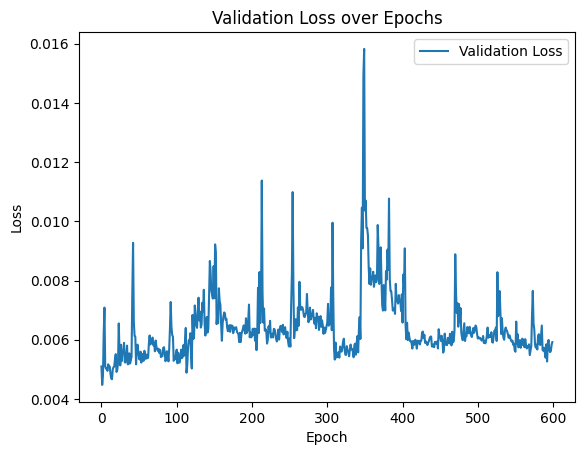

In [25]:
plt.figure()
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss over Epochs')
plt.legend()
plt.show()

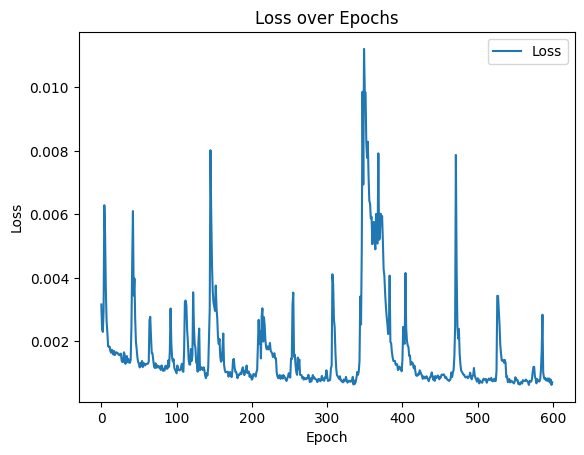

In [30]:
plt.figure()
plt.plot(hist.history['loss'], label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

In [27]:
%%time
model.save(f'./saved_models/model_groc_{STATE}_{TEST_YEAR-1}_{model_name}.keras')

df_preds_24 = sum_regions_predictions(model, df, enso, TEST_YEAR, columns_to_normalize, True, False)

df_preds_24['adm_1'] = STATE
df_preds_24['adm_0'] = 'BR'
df_preds_24['adm_2'] = pd.NA

df_preds_24.to_csv(f'./predictions/preds_groc_{STATE}_{TEST_YEAR}_{model_name}.csv', index = False)


CPU times: user 5min 5s, sys: 474 ms, total: 5min 6s
Wall time: 5min 7s


In [28]:
df_24_base = pd.read_csv(f'./predictions/preds_{STATE}_{TEST_YEAR}_{model_name}.csv')
df_24_base.dates = pd.to_datetime(df_24_base.dates)
df_24_base.head()

,dates,lower,preds,upper,adm_1,adm_0,adm_2
0,2023-10-08,0.000000,0.000000,0.000000,PR,BR,NaN
1,2023-10-15,6.636350,197.222227,655.479658,PR,BR,NaN
2,2023-10-22,0.000000,0.000000,0.000000,PR,BR,NaN
3,2023-10-29,0.000000,21.307679,135.511777,PR,BR,NaN
4,2023-11-05,455.820167,781.161487,1276.419830,PR,BR,NaN


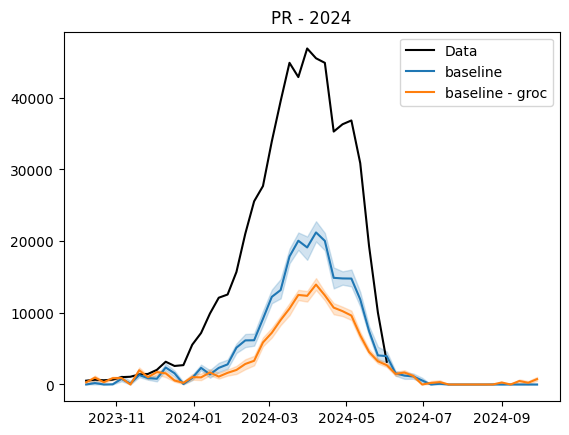

In [29]:
fig,ax = plt.subplots()

ax.plot(data_w.loc[data_w.index.isin(df_24_base.dates)].casos, label = 'Data', color = 'black')
ax.plot(df_24_base.dates, df_24_base.preds, label ='baseline')
ax.fill_between(df_24_base.dates, df_24_base.lower, df_24_base.upper,  color = 'tab:blue', alpha = 0.2)


ax.plot(df_preds_24.dates, df_preds_24.preds, label ='baseline - groc')

ax.fill_between(df_preds_24.dates, df_preds_24.lower, df_preds_24.upper, color = 'tab:orange', alpha = 0.2)

ax.legend()

ax.set_title(f'{STATE} - {TEST_YEAR}')

plt.show()